In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import time
import random
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


In [2]:
FILE_PATH = "C://Users/park9/HAR/BP/p003949.mat"
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [3]:
def seed_everything(seed):
    """
    모든 random seed를 고정하는 함수
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42 
seed_everything(SEED)

print(f"Random seed set to {SEED}")

Random seed set to 42


In [4]:
def load_data(mat_path):

    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']

        ppg_list = [f[r][()].squeeze() for r in refs['PPG_F'][0]]
        ecg_list = [f[r][()].squeeze() for r in refs['ECG_F'][0]]
        sbp_list = [f[r][()][0][0] for r in refs['SegSBP'][0]]
        dbp_list = [f[r][()][0][0] for r in refs['SegDBP'][0]]

        ppg_all = np.array(ppg_list, dtype=np.float32)
        ecg_all = np.array(ecg_list, dtype=np.float32)
        sbp_all = np.array(sbp_list, dtype=np.float32)
        dbp_all = np.array(dbp_list, dtype=np.float32)

    print(f'PPG 신호 shape:  {ppg_all.shape}')
    print(f'ECG 신호 shape:  {ecg_all.shape}')
    print(f'SBP 신호 shape:  {sbp_all.shape}')
    print(f'DBP 신호 shape:  {dbp_all.shape}')

    return ppg_all, ecg_all, sbp_all, dbp_all

In [5]:
def chronological_split(X_data, y_data, n_folds=5, n_total_segments=2000):

    # 1600개 segment만 사용 
    X = X_data[:n_total_segments]
    y = y_data[:n_total_segments]

    print(f"X: {X.shape}, y: {y.shape}")

    fold_size = n_total_segments // n_folds
    test_size = 100
    train_val_size = fold_size - test_size

    folds=[]
    for i in range(n_folds):
        start_idx = i * fold_size
        end_idx = start_idx + fold_size

        X_fold = X[start_idx: end_idx]
        y_fold = y[start_idx: end_idx]

        X_train_val = X_fold[:train_val_size]
        y_train_val = y_fold[:train_val_size]

        X_test = X_fold[train_val_size:]
        y_test = y_fold[train_val_size:]

        folds.append((X_train_val, X_test, y_train_val, y_test))
        print(f"Fold {i+1}: Train/Val=(~{start_idx+train_val_size-1}),\
                Test=({start_idx+train_val_size}~{end_idx-1})")
        
    return folds

In [6]:
class CNN_LSTM_Regressor(nn.Module):
    def __init__(self, cnn_output_channels=128, lstm_hidden_size=256, lstm_num_layers=1):
        super().__init__()

        self.cnn_extractor = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2), # 길이: 1250 -> 625

            nn.Conv1d(32, 64, kernel_size=7, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2), # 길이: 625 -> 312

            nn.Conv1d(64, cnn_output_channels, kernel_size=7, padding='same'),
            nn.BatchNorm1d(cnn_output_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)  # 길이: 312 -> 156
        )

        self.lstm = nn.LSTM(
            input_size=cnn_output_channels,  # CNN의 마지막 출력 채널 수
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True  # (배치, 시퀀스, 특징) 순서
        )

        # Regressor (Classifier 대신)
        self.regressor = nn.Sequential(
            nn.Linear(lstm_hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # 최종 출력 2개: SBP, DBP
        )

    def forward(self, x):
        # 입력: (배치, 길이, 채널)
        x = x.permute(0, 2, 1) # CNN 입력을 위해 (배치, 채널, 길이)로 변경
        
        # CNN 특징 추출
        features = self.cnn_extractor(x)
        
        # LSTM 입력을 위해 (배치, 시퀀스 길이, 특징 수)로 변경
        features = features.permute(0, 2, 1)
        
        # LSTM 처리
        # LSTM은 마지막 hidden state인 hn만 사용
        _, (hn, _) = self.lstm(features)
        
        # 마지막 레이어의 hidden state 사용 (many-to-one 구조)
        out = hn[-1]
        
        # 최종 회귀 예측
        out = self.regressor(out)
        return out

In [7]:
class ResidualBlock1D(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class Attention(nn.Module):
    # (v의 초기화 방식만 수정)
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Parameter(torch.randn(hidden_size))
        self.softmax = nn.Softmax(dim=1)
    def forward(self, seq_output):
        energy = torch.tanh(self.attn(seq_output))
        attn_scores = torch.einsum('bij,j->bi', energy, self.v)
        attention_weights = self.softmax(attn_scores)
        context_vector = torch.einsum('bi,bij->bj', attention_weights, seq_output)
        return context_vector, attention_weights

class ResNet_Attention_Regressor(nn.Module):
    def __init__(self, input_channels=1, n_outputs=2):
        super().__init__()
        # 초기 Conv 레이어
        self.initial_conv = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.initial_bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Residual 블록
        self.layer1 = ResidualBlock1D(64, 64)
        self.layer2 = ResidualBlock1D(64, 128, stride=2)
        self.layer3 = ResidualBlock1D(128, 256, stride=2)

        # Attention 레이어
        self.attention = Attention(256)

        # 최종 Regressor
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, n_outputs) # SBP, DBP 2개 값 출력
        )

    def forward(self, x):
        # 입력: (배치, 길이, 채널)
        x = x.permute(0, 2, 1) # (배치, 채널, 길이)로 변경

        # 초기 Conv + Pooling
        x = self.maxpool(self.relu(self.initial_bn(self.initial_conv(x))))
        
        # ResNet 블록 통과
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Attention을 위한 차원 변경 (채널을 마지막 차원으로)
        x = x.permute(0, 2, 1)
        
        # Attention 적용
        context_vector, _ = self.attention(x)
        
        # 최종 회귀 예측
        output = self.regressor(context_vector)
        return output

In [8]:
def train_model_v2(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience=10):
    """학습률 스케줄러와 조기 종료가 포함된 훈련 함수"""
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # 검증(Validation) 단계
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        
        val_loss /= len(val_loader)
        
        # 학습률 스케줄러 업데이트
        scheduler.step(val_loss)
        
        # 조기 종료(Early Stopping) 로직
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth') # 최고 성능 모델 저장
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Val Loss: {val_loss:.4f}')

        if patience_counter >= patience:
            print(f"조기 종료: {patience} 에포크 동안 성능 개선 없음")
            break
            
    model.load_state_dict(torch.load('best_model.pth')) # 최고 성능 모델 불러오기
    return model

In [9]:
def evaluate_model(model, test_loader, device):
    """훈련된 모델 평가를 위한 함수"""
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            outputs = model(inputs.to(device))
            all_preds.append(outputs.cpu().numpy())
    return np.concatenate(all_preds, axis=0)

In [10]:
def plot_prediction(y_true, y_pred, fold_idx):
    """
    실제값, 예측값, 그리고 예측 범위를 함께 시각화하는 함수
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    colors = {
        'true': '#007ACC',      # 시원한 파란색
        'pred_sbp': '#FF4500',  # 강조되는 주황색
        'range_sbp': '#FFC1B5', # 연한 주황색
        'pred_dbp': '#2CA02C',  # 차분한 녹색
        'range_dbp': '#B8E0B8', # 연한 녹색
        'text': '#333333'
    }

    # SBP/DBP 분리 및 MAE 계산
    sbp_true, dbp_true = y_true[:, 0], y_true[:, 1]
    sbp_pred, dbp_pred = y_pred[:, 0], y_pred[:, 1]
    
    mae_sbp = np.mean(np.abs(sbp_true - sbp_pred))
    mae_dbp = np.mean(np.abs(dbp_true - dbp_pred))
    
    # x축으로 사용할 인덱스 생성
    x_axis = np.arange(len(sbp_true))

    # --- 시각화 ---
    fig, axes = plt.subplots(2, 1, figsize=(18, 11), sharex=True)
    fig.suptitle(f'Fold {fold_idx+1} Test Set Predictions with Error Range', fontsize=22, weight='bold', color=colors['text'])
    fig.patch.set_facecolor('#F8F8F8')

    # --- SBP Plot ---
    ax1 = axes[0]
    ax1.fill_between(x_axis, (sbp_pred - mae_sbp), (sbp_pred + mae_sbp), 
                     color=colors['range_sbp'], alpha=0.7, label=f'Prediction Range (±{mae_sbp:.2f} MAE)')
    ax1.plot(x_axis, sbp_true, color=colors['true'], label='True SBP', linewidth=2)
    ax1.plot(x_axis, sbp_pred, color=colors['pred_sbp'], label='Predicted SBP', linewidth=2.5, linestyle='--')
    
    ax1.set_title('Systolic Blood Pressure (SBP)', fontsize=16, color=colors['text'], pad=10)
    ax1.set_ylabel('mmHg', fontsize=12, color=colors['text'])
    ax1.tick_params(axis='both', which='major', labelsize=11)
    ax1.legend(fontsize=12, loc='upper right')
    ax1.set_facecolor('#FFFFFF') # Plot 배경색

    # --- DBP Plot ---
    ax2 = axes[1]
    ax2.fill_between(x_axis, (dbp_pred - mae_dbp), (dbp_pred + mae_dbp), 
                     color=colors['range_dbp'], alpha=0.7, label=f'Prediction Range (±{mae_dbp:.2f} MAE)')
    ax2.plot(x_axis, dbp_true, color=colors['true'], label='True DBP', linewidth=2)
    ax2.plot(x_axis, dbp_pred, color=colors['pred_dbp'], label='Predicted DBP', linewidth=2.5, linestyle='--')

    ax2.set_title('Diastolic Blood Pressure (DBP)', fontsize=16, color=colors['text'], pad=10)
    ax2.set_xlabel('Test Sample Index', fontsize=14, color=colors['text'], labelpad=10)
    ax2.set_ylabel('mmHg', fontsize=12, color=colors['text'])
    ax2.tick_params(axis='both', which='major', labelsize=11)
    ax2.legend(fontsize=12, loc='upper right')
    ax2.set_facecolor('#FFFFFF')

    # 테두리 정리
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


PPG 신호 shape:  (2376, 1250)
ECG 신호 shape:  (2376, 1250)
SBP 신호 shape:  (2376,)
DBP 신호 shape:  (2376,)
X: (2000, 1250, 1), y: (2000, 2)
Fold 1: Train/Val=(~299),                Test=(300~399)
Fold 2: Train/Val=(~699),                Test=(700~799)
Fold 3: Train/Val=(~1099),                Test=(1100~1199)
Fold 4: Train/Val=(~1499),                Test=(1500~1599)
Fold 5: Train/Val=(~1899),                Test=(1900~1999)

===== Fold 1/4 시작 =====
Epoch [10/150], Val Loss: 4208.8945
Epoch [20/150], Val Loss: 40.6719
Epoch [30/150], Val Loss: 9.2174
조기 종료: 10 에포크 동안 성능 개선 없음
Fold 1: 모델 평가 중...
Fold 1 완료. (소요 시간: 4.32초)


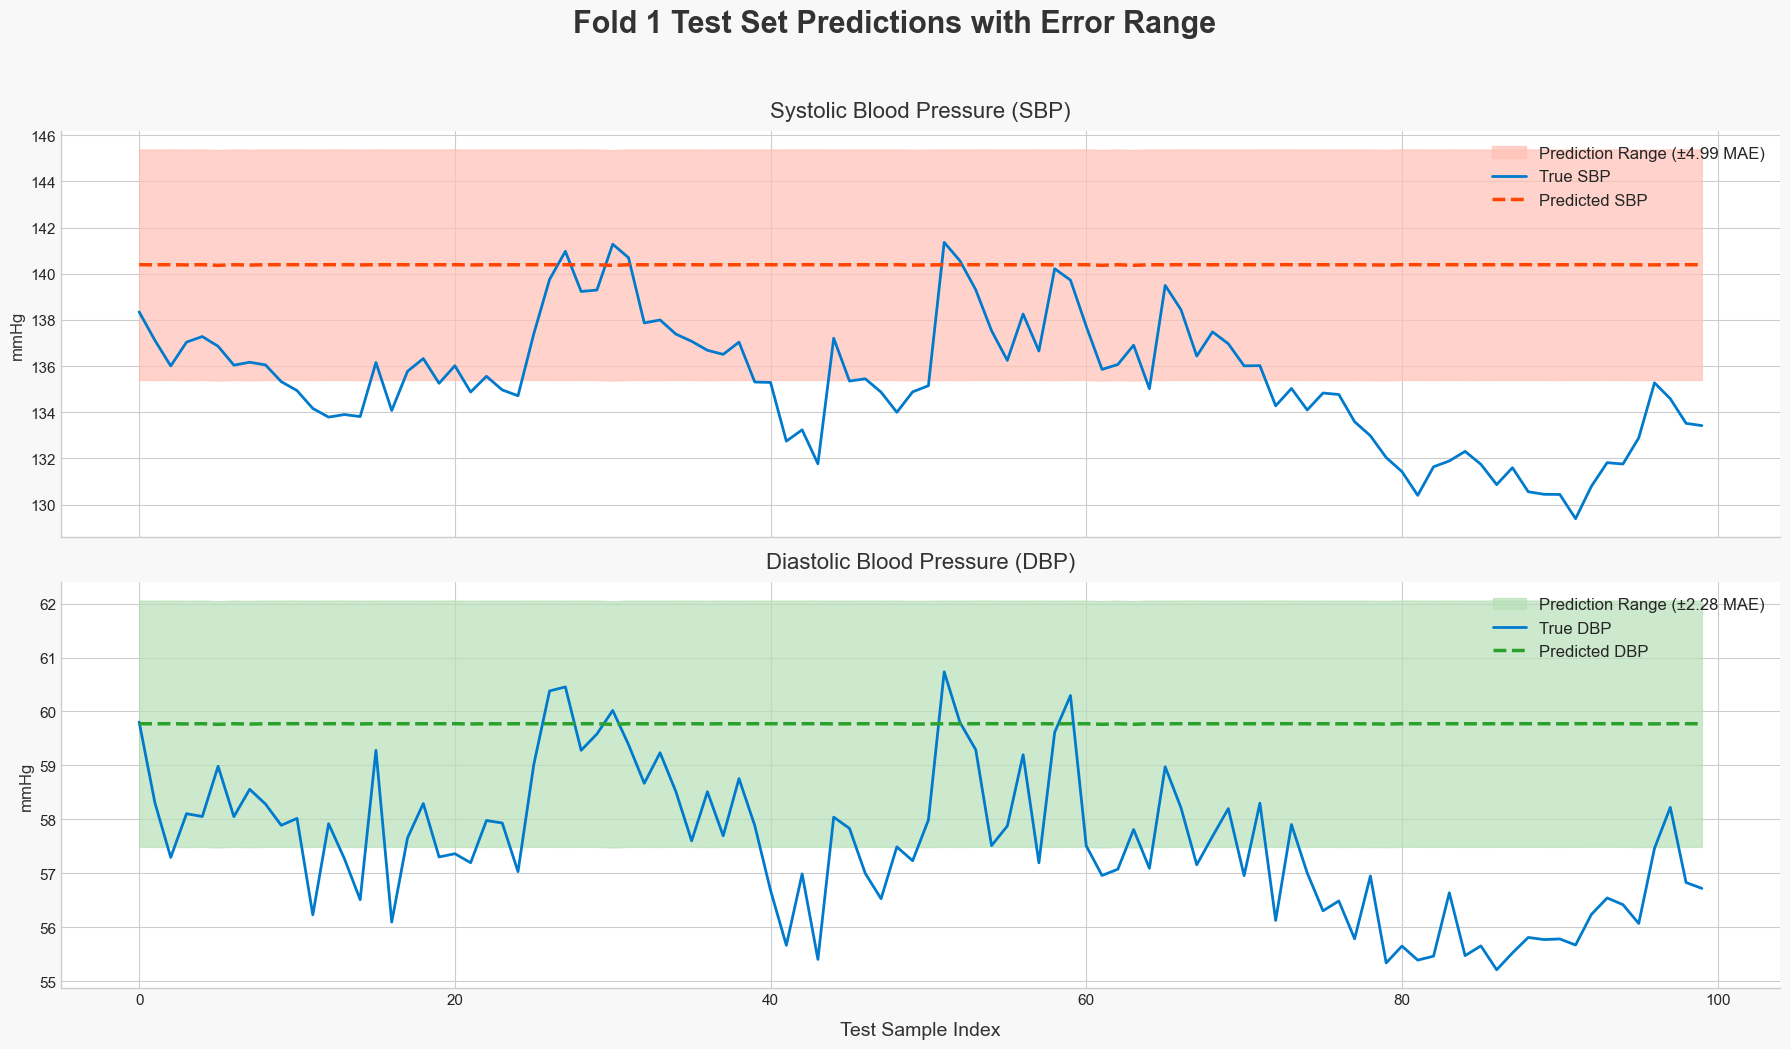


===== Fold 2/4 시작 =====
Epoch [10/150], Val Loss: 2575.1013
Epoch [20/150], Val Loss: 57.7153
Epoch [30/150], Val Loss: 10.0285
Epoch [40/150], Val Loss: 18.6319
조기 종료: 10 에포크 동안 성능 개선 없음
Fold 2: 모델 평가 중...
Fold 2 완료. (소요 시간: 3.52초)


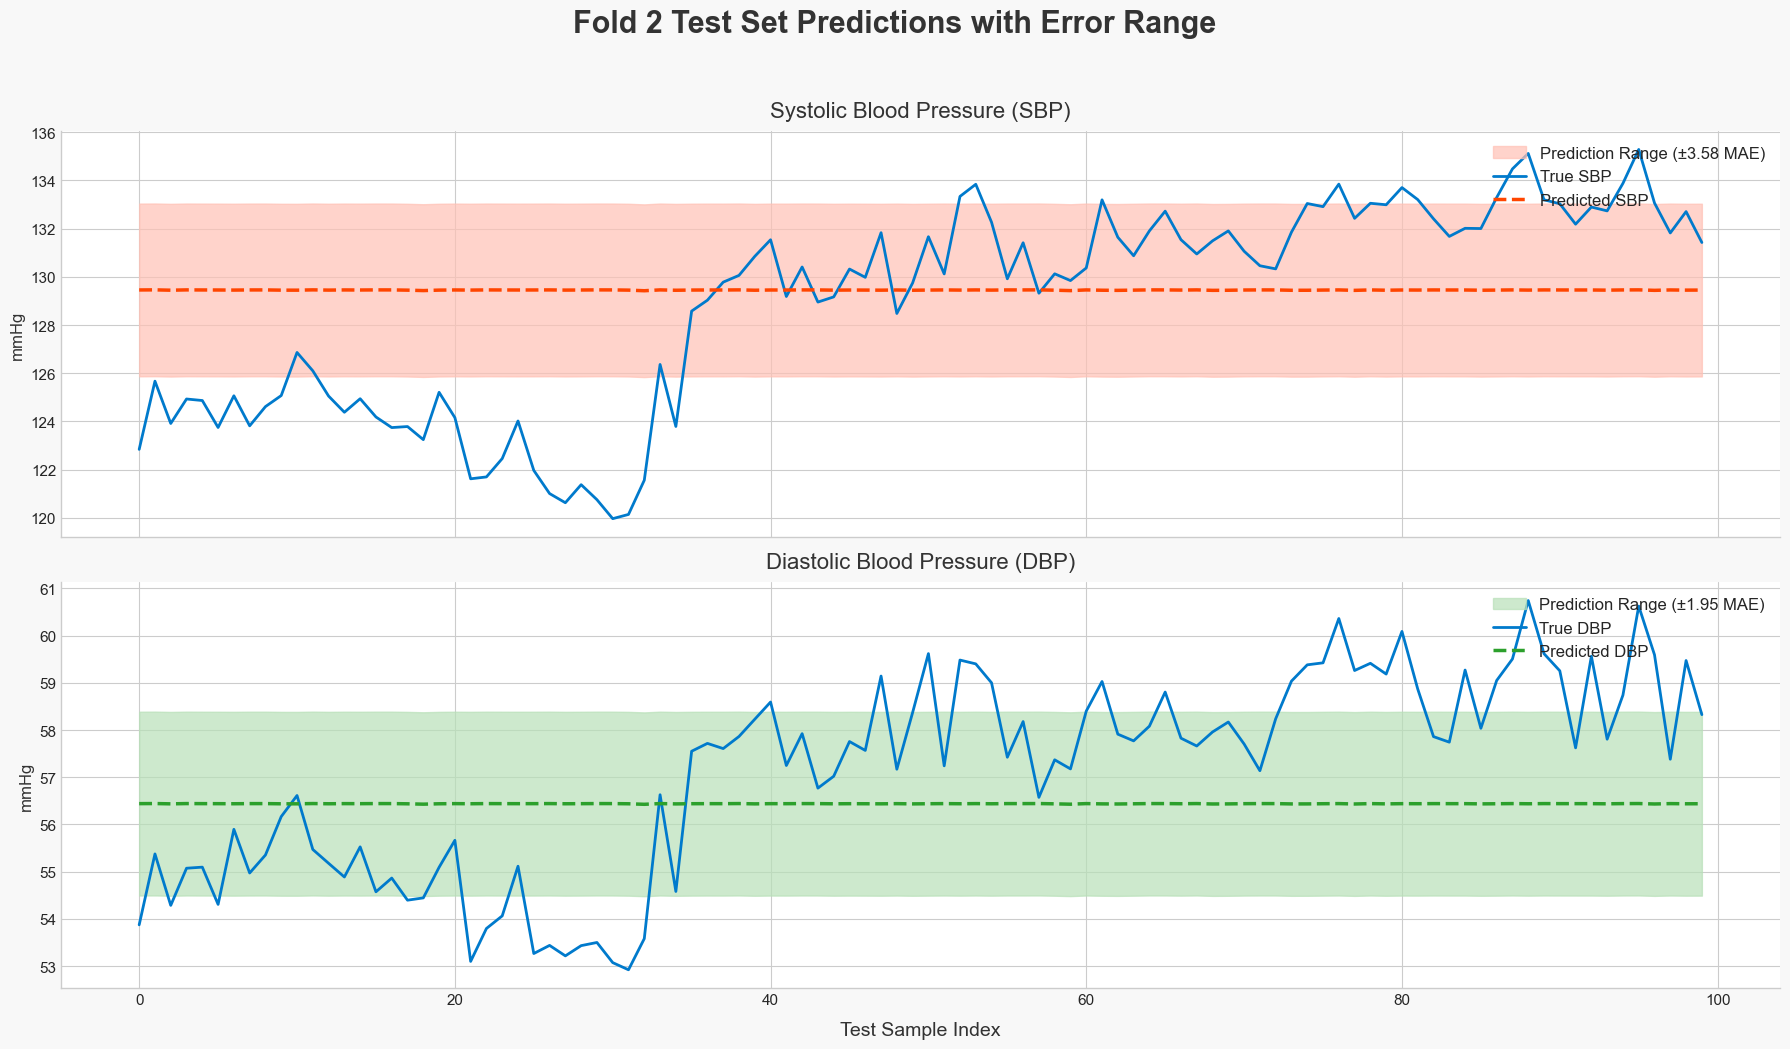


===== Fold 3/4 시작 =====
Epoch [10/150], Val Loss: 3847.7966
Epoch [20/150], Val Loss: 37.9189
Epoch [30/150], Val Loss: 9.9742
조기 종료: 10 에포크 동안 성능 개선 없음
Fold 3: 모델 평가 중...
Fold 3 완료. (소요 시간: 2.85초)


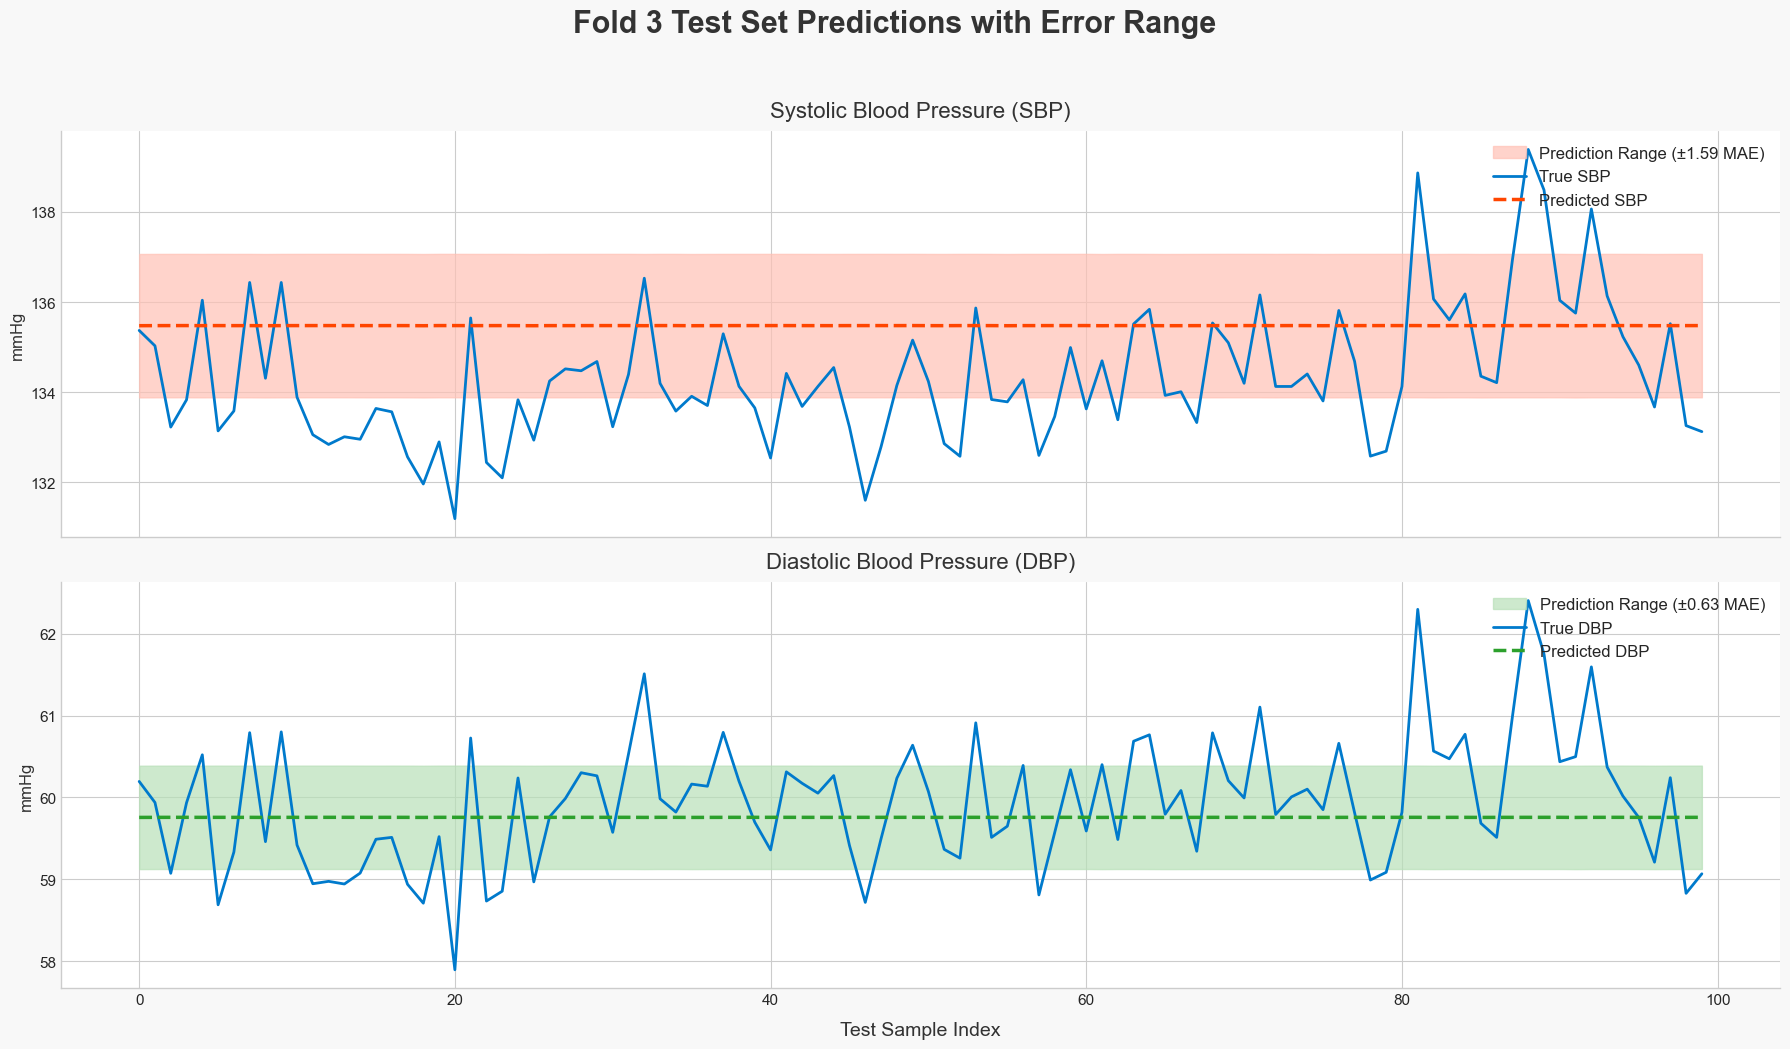


===== Fold 4/4 시작 =====
Epoch [10/150], Val Loss: 3856.8682
Epoch [20/150], Val Loss: 31.8263
Epoch [30/150], Val Loss: 3.5669
조기 종료: 10 에포크 동안 성능 개선 없음
Fold 4: 모델 평가 중...
Fold 4 완료. (소요 시간: 2.73초)


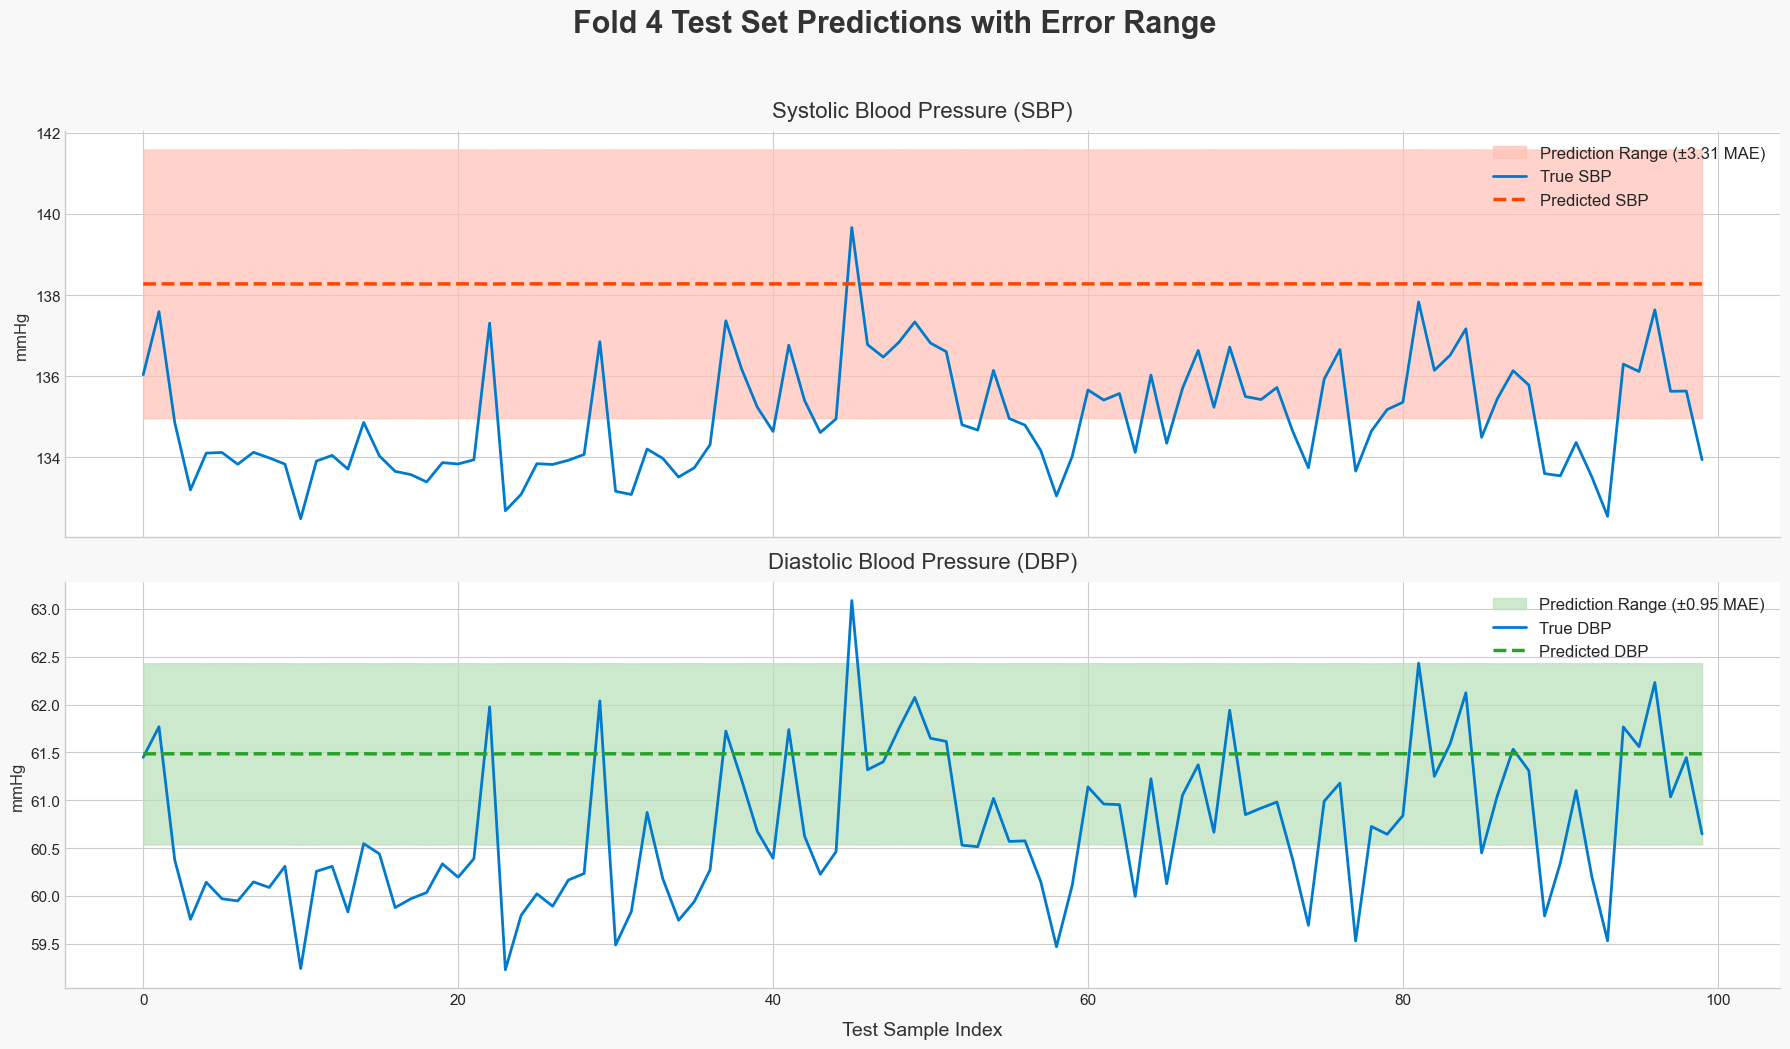


===== Fold 5/4 시작 =====
Epoch [10/150], Val Loss: 2722.4116
Epoch [20/150], Val Loss: 23.3828
Epoch [30/150], Val Loss: 3.7190
조기 종료: 10 에포크 동안 성능 개선 없음
Fold 5: 모델 평가 중...
Fold 5 완료. (소요 시간: 3.34초)


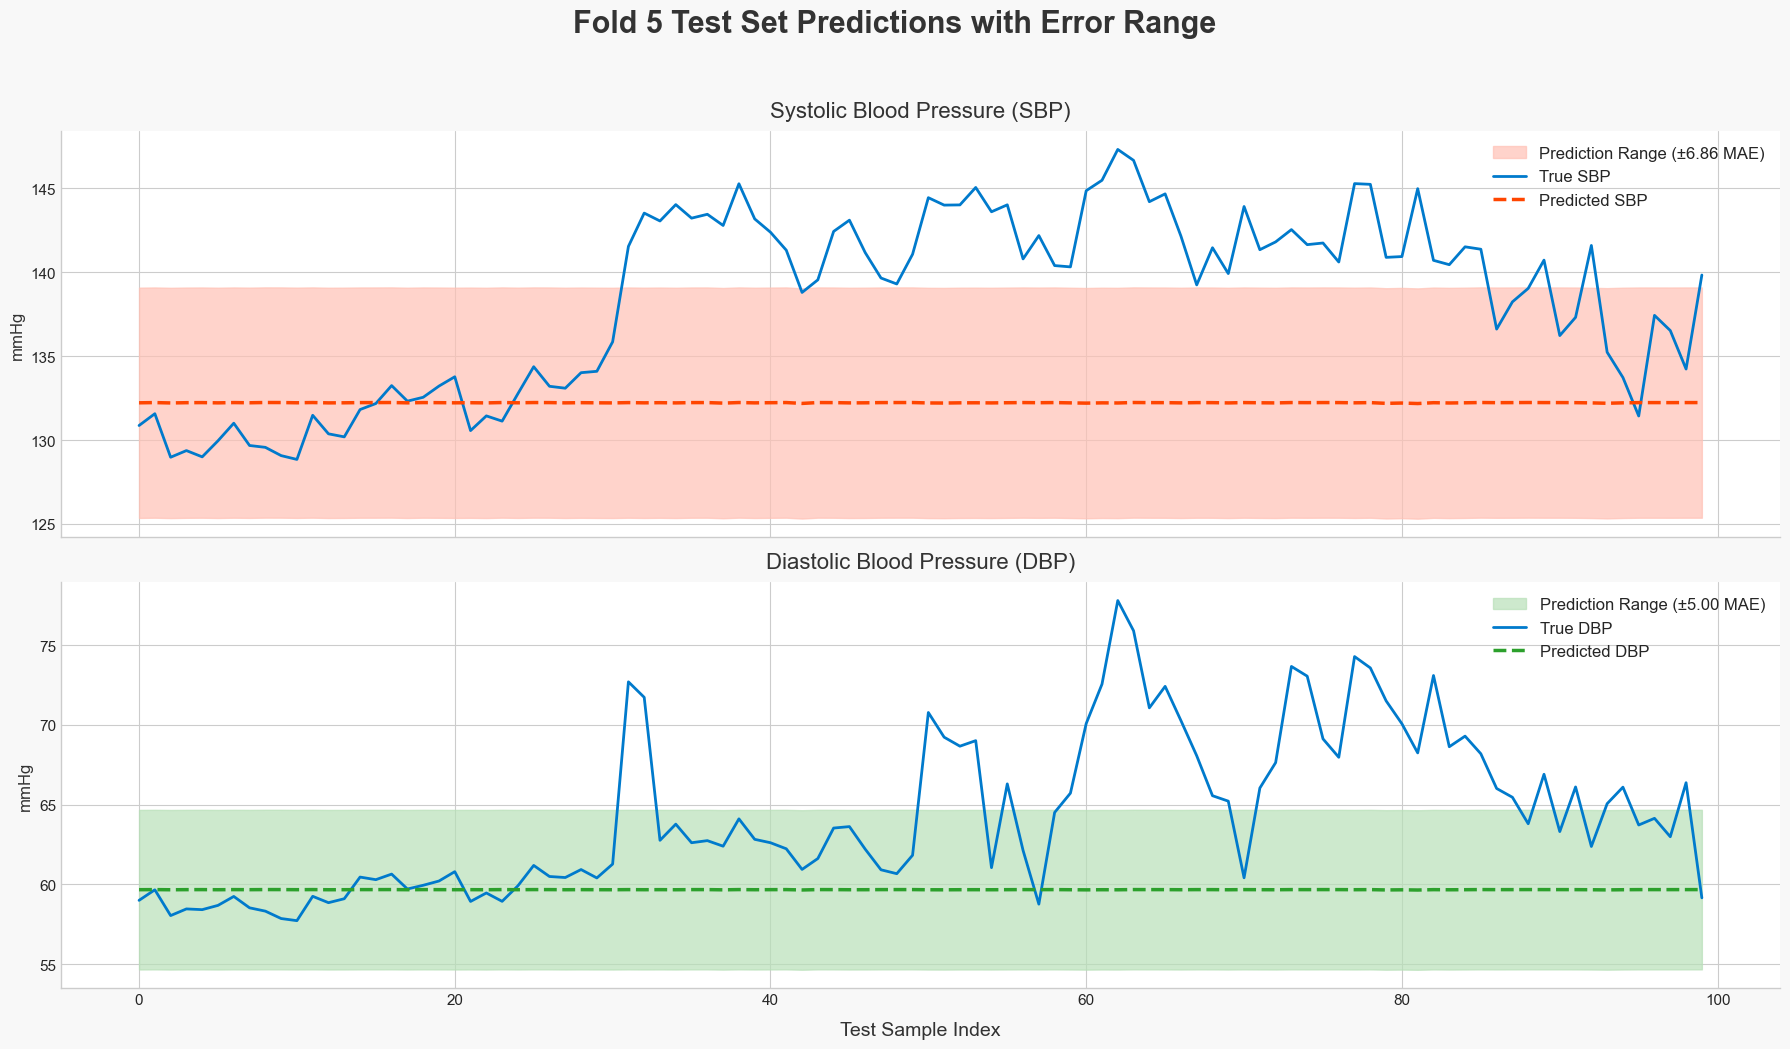

In [11]:
ppg, _, sbp, dbp = load_data(FILE_PATH)
X_ppg_only = ppg[..., np.newaxis]
y_labels = np.stack([sbp, dbp], axis=-1)
all_folds_data = chronological_split(X_ppg_only, y_labels)

fold_results = []
for i, (X_train_val, X_test, y_train_val, y_test) in enumerate(all_folds_data):
    start_time = time.time()
    print(f"\n===== Fold {i+1}/4 시작 =====")

    # 1. 데이터 준비 (분할, 스케일링, DataLoader 생성)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, shuffle=False
    )
    scaler = StandardScaler().fit(X_train.reshape(-1, X_train.shape[-1]))
    X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    
    train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # 2. 모델 초기화 및 훈련
    model = CNN_LSTM_Regressor().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    
    model = train_model_v2(model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE, EPOCHS)
    
    # 3. 모델 평가
    print(f"Fold {i+1}: 모델 평가 중...")
    y_pred = evaluate_model(model, test_loader, DEVICE)
    
    # 4. 성능 지표 계산
    mae_sbp = np.mean(np.abs(y_test[:, 0] - y_pred[:, 0]))
    mae_dbp = np.mean(np.abs(y_test[:, 1] - y_pred[:, 1]))
    rmse_sbp = np.sqrt(np.mean((y_test[:, 0] - y_pred[:, 0])**2))
    rmse_dbp = np.sqrt(np.mean((y_test[:, 1] - y_pred[:, 1])**2))

    fold_results.append({
        'Fold': i+1,
        'SBP MAE': mae_sbp, 'DBP MAE': mae_dbp,
        'SBP RMSE': rmse_sbp, 'DBP RMSE': rmse_dbp
    })
    
    end_time = time.time()
    print(f"Fold {i+1} 완료. (소요 시간: {end_time - start_time:.2f}초)")

    # 5. 그래프 시각화 (요구사항 2)
    plot_prediction(y_test, y_pred, i)

In [12]:
results_df = pd.DataFrame(fold_results).set_index('Fold')

# --- 평균 및 표준편차 계산 ---
summary = results_df.agg(['mean', 'std'])

print("\n\n ===== 최종 결과 요약 (PyTorch PPG 모델) =====")
print(results_df.round(3))
print("\n--- 평균 및 표준편차 ---")
print(summary.round(3))



 ===== 최종 결과 요약 (PyTorch PPG 모델) =====
      SBP MAE  DBP MAE  SBP RMSE  DBP RMSE
Fold                                      
1       4.992    2.283     5.630     2.589
2       3.583    1.947     4.279     2.177
3       1.592    0.632     1.871     0.807
4       3.312    0.947     3.567     1.109
5       6.863    4.999     8.121     6.747

--- 평균 및 표준편차 ---
      SBP MAE  DBP MAE  SBP RMSE  DBP RMSE
mean    4.068    2.161     4.694     2.686
std     1.975    1.727     2.347     2.386
